# Advanced SQL project

## Imports and basic settings

In [64]:
import pandas as pd
from yaml import load, FullLoader
from sqlalchemy import create_engine

In [65]:
config = load(open('config.yaml'), Loader=FullLoader)

In [66]:
user = config['db_config']['user']
pwd = config['db_config']['pwd']
host = config['db_config']['host']
port = config['db_config']['port']
db = config['db_config']['db']

In [67]:
connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
    user,
    pwd,
    host,
    port,
    db,
) 

In [68]:
con = create_engine(connection_string) 

In [69]:
def select(sql):
  return pd.read_sql(sql,con)

## ER diagram

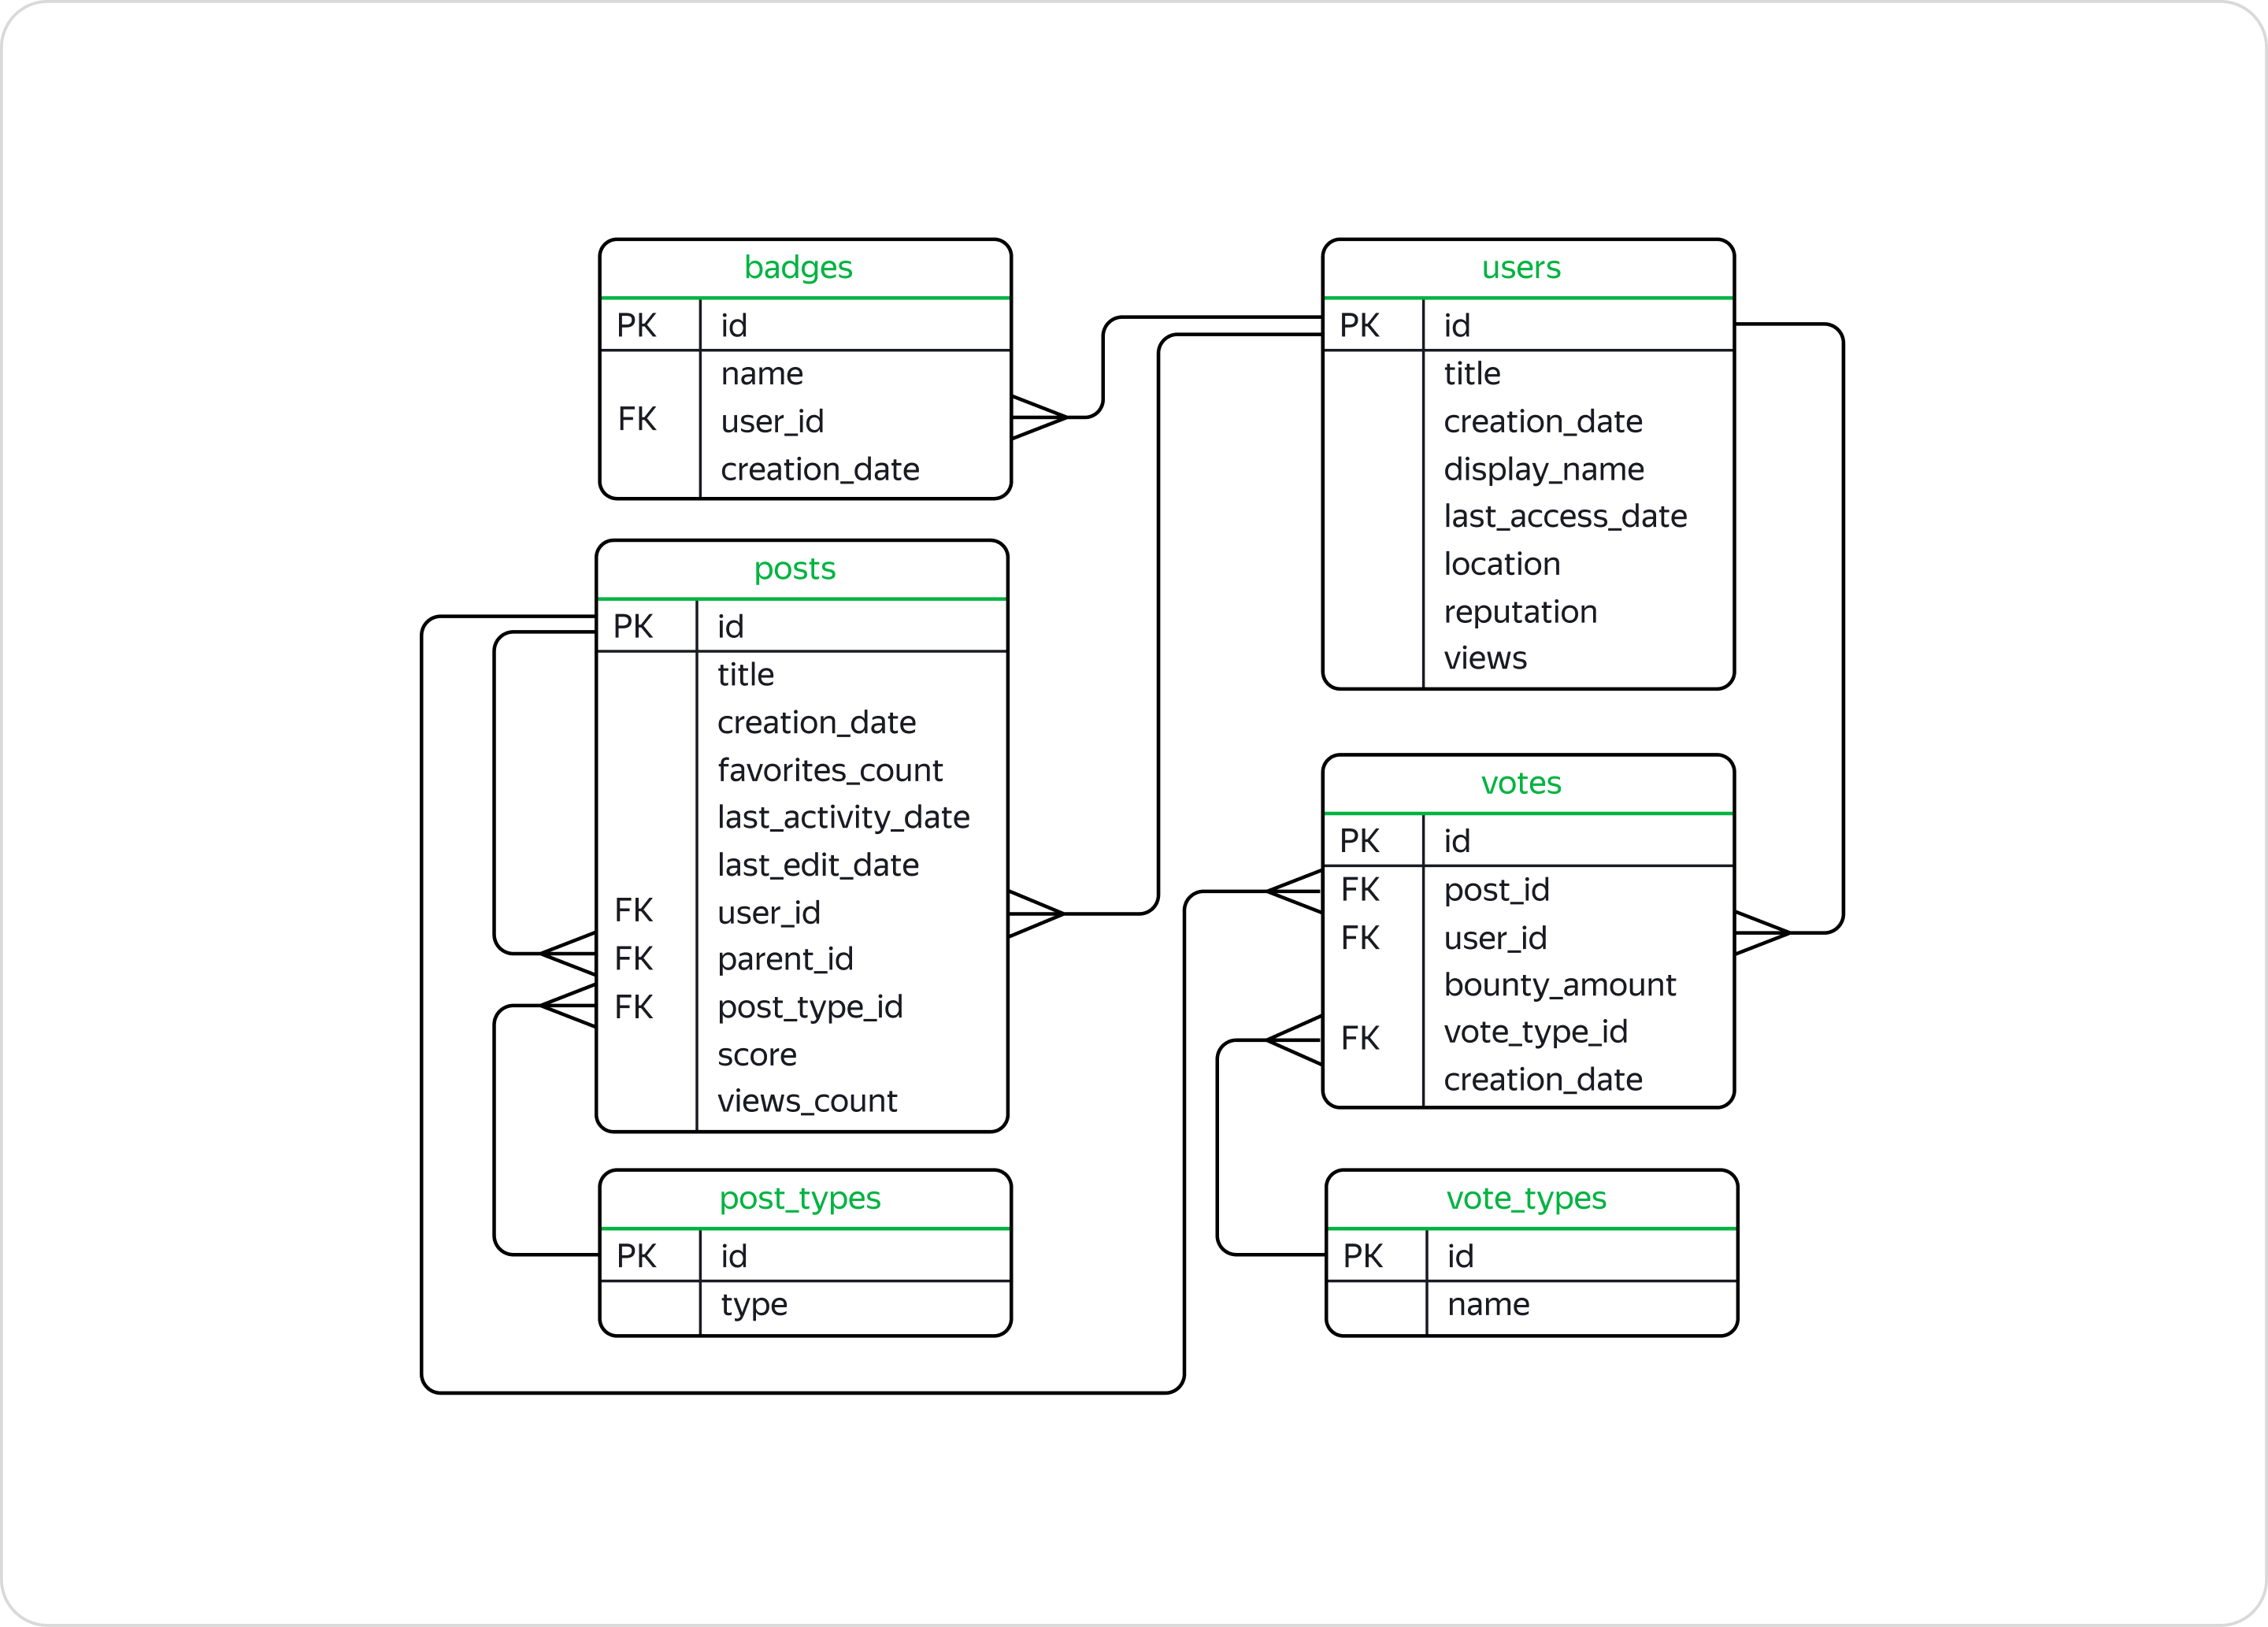

## Database description

* StackOverflow database with partial data for 2008

### Table `badges`

* Stores information about the badges that are awarded for various achievements. For example, a user who correctly answers a large number of questions about PostgreSQL may receive a postgresql badge  


* **id**; table primary key - badge id
* **name**; badge name
* **user_id**; foreign key to table `users` - user id to whom the badge was assigned
* **creation_date**; badge creation date

### Table `posts`

* Stores info about the posts 


* **id**; table primary key - post id
* **title**; post title
* **creation_date**; post creation date
* **favorites_count**; number that shows how many times the post has been bookmarked
* **last_activity_date**; date of the last activity in the post, such as a comment
* **last_edit_date**; date the post was last modified
* **user_id**; foreign key to table `users` - user id who created the post
* **parent_id**; if the post was written in response to another post, this field will contain post id with the question
* **post_type_id**; foreign key to table `post_types` - post type id
* **score**; number of points the post has scored
* **views_count**; number of views

### Table `post_types`

* Stores info about the posts types


* **id**; table primary key - post type id
* **type**; post type

### Table `users`

* Stores info about the users 


* **id**; table primary key - user id
* **creation_date**; user registration date
* **display_name**; user name
* **last_access_date**; date of the last access
* **location**; user location
* **reputation**; reputation points earned for good questions and helpful answers
* **views**; number of user profile views

### Table `votes`

* Stores info about the post votes 


* **id**; table primary key - vote id
* **post_id**; foreign key to table `posts` - post id
* **user_id**; foreign key to table `users` - user id who gave a vote
* **bounty_amount**; amount of reward that is assigned to draw attention to the post
* **vote_type_id**; foreign key to table `vote_types` - vote type id
* **creation_date**; vote creation date

### Table `vote_types`

* Stores info about the vote types


* **id**; table primary key - vote type id
* **name**; vote name

## Exercise 1

Find the number of questions that have scored more than 300 points or have been bookmarked at least 100 times

In [70]:
sql = '''
select count(p.id)
from stackoverflow.posts as p
where p.post_type_id=1 and (p.score>300 or p.favorites_count>=100)'''

In [71]:
select(sql)

,count
0,1355


## Exercise 2

How many questions per day, on average, were asked from November 1 to November 18, 2008 inclusive? Round the result to the nearest whole number

In [72]:
sql = '''
with daily_cnt as (select date_trunc('day', p.creation_date)::date as day,
count(p.id)
from stackoverflow.posts as p
where p.post_type_id = 1 and p.creation_date between '2008-11-01' and '2008-11-19'
group by day)

select round(avg(count))
from daily_cnt'''

In [73]:
select(sql)

,round
0,383.0


## Exercise 3

How many users received badges on the day of registration? Print the number of unique users

In [74]:
sql = '''
with time_diff as (select b.user_id,
b.creation_date::date - u.creation_date::date as diff
from stackoverflow.badges as b
join stackoverflow.users as u on b.user_id=u.id)

select count(distinct user_id)
from time_diff
where diff=0
'''

In [75]:
select(sql)

,count
0,7047


## Exercise 4

How many unique posts by a user named Joel Coehoorn have received at least one upvote?

In [76]:
sql = '''
select count(distinct v.post_id)
from stackoverflow.votes as v
where v.post_id in (select distinct p.id
from stackoverflow.posts as p
where p.user_id in (select id
from stackoverflow.users
where display_name='Joel Coehoorn'))
'''

In [77]:
select(sql)

,count
0,12


## Exercise 5

Select all fields of the `vote_types` table. Add a rank field to the table, which will include the record numbers in reverse order. The table must be sorted by the id field


In [78]:
sql = '''
select *,
row_number() over (order by id desc) as rank
from stackoverflow.vote_types
order by id
'''

In [79]:
select(sql)

,id,name,rank
0,1,AcceptedByOriginator,15
1,2,UpMod,14
2,3,DownMod,13
3,4,Offensive,12
4,5,Favorite,11
...,...,...,...
10,11,Undeletion,5
11,12,Spam,4
12,13,InformModerator,3
13,14,ModeratorReview,2


## Exercise 6

Select 10 users who put the most `close` votes. Display a table with two fields: user id and number of votes. Sort the data first in descending order of the number of votes, then in descending order of the user id value

In [80]:
sql = '''
select v.user_id,
count(v.id)
from stackoverflow.votes as v
where v.vote_type_id=6
group by v.user_id
order by count desc, user_id desc
limit 10
'''

In [81]:
select(sql)

,user_id,count
0,20646,36
1,14728,36
2,27163,29
3,41158,24
4,24820,23
5,9345,23
6,3241,23
7,44330,20
8,38426,19
9,19074,19


## Exercise 7

Select 10 users based on the number of badges received between November 15 and December 15, 2008 inclusive. 

Display multiple fields:
* user id
* number of badges
* place in the rating - the more badges, the higher the rating

Users who have scored the same number of badges are assigned the same place in the ranking.
Sort the entries by the number of icons in descending order and then in ascending order of the user id value.

In [82]:
sql = '''
with cnt as (select b.user_id,
count(b.id)
from stackoverflow.badges as b
where b.creation_date between '2008-11-15' and '2008-12-16'
group by b.user_id
order by count desc, user_id
limit 10)

select *,
dense_rank() over (order by count desc) as rnk
from cnt
order by count desc, user_id
'''

In [83]:
select(sql)

,user_id,count,rnk
0,22656,149,1
1,34509,45,2
2,1288,40,3
3,5190,31,4
4,13913,30,5
5,893,28,6
6,10661,28,6
7,33213,25,7
8,12950,23,8
9,25222,20,9


## Exercise 8

How many points does each user's post get on average?

Create a table from the following fields:
* post title;
* user id;
* number of post points;
* average number of user points per post, rounded to the nearest whole number.

Don't count posts without a title or those that score zero points.

In [84]:
sql = '''
select p.title,
p.user_id,
p.score,
round(avg(p.score) over (partition by p.user_id)) as avg_score_by_user
from stackoverflow.posts as p
where p.title<>'' and p.score!=0
'''

In [85]:
select(sql)

,title,user_id,score,avg_score_by_user
0,Diagnosing Deadlocks in SQL Server 2005,1,82,573.0
1,How do I calculate someone's age in C#?,1,1743,573.0
2,Why doesn't IE7 copy <pre><code> blocks to the clipboard correctly?,1,37,573.0
3,Calculate relative time in C#,1,1348,573.0
4,Wrapping StopWatch timing with a delegate or lambda?,1,92,573.0
...,...,...,...,...
47349,Multi-lingual projects in Visual Studio,3742716,1,1.0
47350,Change datatype when importing Excel file into Access,3930756,5,5.0
47351,How to host a Silverlight app in a Sharepoint 2007 Web Part,4020932,8,8.0
47352,Getting counts for a paged SQL search stored procedure,5696608,2,2.0


## Exercise 9

Select posts titles that were written by users who received more than 1000 badges. Posts without titles should not be included in the list.

In [86]:
sql = '''
with badge_cnt as 
(select b.user_id,
count(b.id)
from stackoverflow.badges as b
group by b.user_id)

select p.title
from stackoverflow.posts as p
where p.user_id in (select user_id from badge_cnt where count>=1000) and 
p.title<>''
'''

In [87]:
select(sql)

,title
0,What's the strangest corner case you've seen in C# or .NET?
1,What's the hardest or most misunderstood aspect of LINQ?
2,What are the correct version numbers for C#?
3,Project management to go with GitHub


## Exercise 10

Calculate the daily increase in new users in November 2008. 

Create a table with fields:
* day number;
* number of users registered that day;
* the amount of users with accumulation.

In [88]:
sql = '''
select extract(day from u.creation_date) as day,
count(u.id) as cnt_users_reg,
sum(count(u.id)) over (order by extract(day from u.creation_date)) as cumsum_users_reg
from stackoverflow.users as u
where u.creation_date between '2008-11-01' and '2008-12-01'
group by day
order by day
'''

In [89]:
select(sql)

,day,cnt_users_reg,cumsum_users_reg
0,1.0,34,34.0
1,2.0,48,82.0
2,3.0,75,157.0
3,4.0,192,349.0
4,5.0,122,471.0
...,...,...,...
25,26.0,98,2204.0
26,27.0,71,2275.0
27,28.0,56,2331.0
28,29.0,44,2375.0


## Exercise 11

For each user who wrote at least one post, find the interval between registration and the time the first post was created. 

Select:
* user id;
* time difference between registration and first post.

In [90]:
sql = '''
select distinct p.user_id,
min(p.creation_date) over (partition by p.user_id) - u.creation_date as time_diff
from stackoverflow.posts as p
join stackoverflow.users as u on p.user_id=u.id
'''

In [91]:
select(sql)

,user_id,time_diff
0,1,0 days 09:18:29
1,2,0 days 14:37:03
2,3,3 days 16:17:09
3,4,15 days 05:44:22
4,5,1 days 14:57:51
...,...,...
18844,3644960,0 days 00:00:00
18845,3742716,66 days 21:15:48
18846,3930756,8 days 02:11:55
18847,4020932,47 days 18:30:34


## Exercise 12

Select the total sum of post views for each month of 2008. 

If there is no data for any month in the database, this month can be skipped. 

Sort the result in descending order of the total number of views.

In [92]:
sql = '''
select date_trunc('month', p.creation_date)::date as month,
sum(views_count)
from stackoverflow.posts as p
where extract(year from p.creation_date)=2008
group by month
order by sum desc
'''

In [93]:
select(sql)

,month,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


## Exercise 13

Select the names of the most active users who gave more than 100 answers in the first month after registration (including the day of registration). 

For each username, print the number of unique `user_id` values. 
Sort the result by the field with the names in lexicographic order.

In [94]:
sql = '''
select u.display_name,
count(distinct u.id) AS cnt_unique_users
from stackoverflow.users as u
join stackoverflow.posts as p on p.user_id=u.id
where p.post_type_id = 2
and date_trunc('day', p.creation_date) between date_trunc('day', u.creation_date) 
and date_trunc('day', u.creation_date) + interval '1 month'
group by u.display_name
having count(p.id) > 100
'''

In [95]:
select(sql)

,display_name,cnt_unique_users
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


## Exercise 14

Select the number of posts for 2008 by month. 

Select posts from users who signed up in September 2008 and made at least one post in December of that year. 

Sort the table by month value in descending order.

In [96]:
sql = '''
with reg as (select u.id
from stackoverflow.users as u
where extract(year from u.creation_date)=2008 and extract(month from u.creation_date)=9),

dec_post as (select p.user_id,
1 as flag
from stackoverflow.posts as p
where extract(year from p.creation_date)=2008 and extract(month from p.creation_date)=12 ),

selection as (select id
from reg
join dec_post on reg.id=dec_post.user_id)

select date_trunc('month',p.creation_date)::date as month,
count(distinct p.id)
from stackoverflow.posts as p
join selection as s on p.user_id=s.id
where extract(year from p.creation_date)=2008
group by month
order by month desc
'''

In [97]:
select(sql)

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


## Exercise 15

Select:
* user id who wrote the post;
* the date the post was created;
* the number of views on the current post;
* the amount of views of the author's posts with accumulation.

The data in the table should be sorted in ascending order of user ids, and the data for the same user should be sorted in ascending order of the date the post was created.

In [98]:
sql = '''
select p.user_id,
p.creation_date,
p.views_count,
sum(p.views_count) over (partition by p.user_id order by p.creation_date) as cumsum_views_count
from stackoverflow.posts as p
order by p.user_id
'''

In [99]:
select(sql)

,user_id,creation_date,views_count,cumsum_views_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


## Exercise 16

How many days between 1 December 2008 and 7 December 2008 inclusive on average did users interact with the platform? 

For each user, select the days on which he or she posted at least one post. 

You need to get a single integer - do not forget to round the result

In [100]:
sql = '''
with count as (select p.creation_date::date,
p.user_id,
count(p.creation_date::date)
from stackoverflow.posts as p
where p.creation_date between '2008-12-01' and '2008-12-08'
group by 1,2)

select round(avg(count))
from count
'''

In [101]:
select(sql)

,round
0,2.0


## Exercise 17

Calculate the percentage change in the number of posts monthly from September 1 to December 31, 2008.

Display a table with the following fields:
* month number;
* number of posts per month;
* a percentage that shows how much the number of posts in the current month has changed compared to the previous one.

In [102]:
sql = '''
with monthly as (select extract(month from p.creation_date) as month,
count(p.id) as cnt
from stackoverflow.posts as p
where p.creation_date::date between '2008-09-01' and '2009-01-01'
group by month)

select *,
round((cnt/lag(cnt) over (order by month)::numeric - 1) * 100, 2) as pct_change
from monthly
'''

In [103]:
select(sql)

,month,cnt,pct_change
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


## Exercise 18

Select the activity data of the user who posted the most posts in all the time. 

Display the data for October 2008:
* week number;
* date and time of the last post published this week

In [104]:
sql = '''
with top_user as (select p.user_id,
count(p.id)
from stackoverflow.posts as p
group by p.user_id
order by count desc
limit 1)

select extract(week from p.creation_date) as week,
max(p.creation_date) as last_post
from top_user as t
join stackoverflow.posts as p on t.user_id=p.user_id
where extract(month from p.creation_date)=10 and extract(year from p.creation_date)=2008
group by week
'''

In [105]:
select(sql)

,week,last_post
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
